In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from bqplot import pyplot as plt
#from bqplot import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set()

## Load dataset
consisting of all derived features.

In [2]:
df = pd.read_csv('../data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1)

## Increasing/decreasing-load trainng set


Helper methods for isolating heating/cooling subsets of cycles

In [3]:
def inc(cycle_df):
    start = cycle_df[cycle_df.Min==1].Time.values[0]
    end = cycle_df[cycle_df.Max==1].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

def dec(cycle_df):
    start = cycle_df[cycle_df.Max==1].Time.values[0]
    end = cycle_df.iloc[-1:].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

In [4]:
df_inc, df_dec = pd.DataFrame(), pd.DataFrame()
for cycle in np.arange(1, 47):
    cycle_df = df[df.Cycle==cycle].reset_index()    
    df_inc = df_inc.append(inc(cycle_df))
    df_dec = df_dec.append(dec(cycle_df))
to_drop = ['Datetime', 'index']
df_inc = df_inc.drop(to_drop, axis=1); df_dec = df_dec.drop(to_drop, axis=1)

## Automation via _GridSearchCV_
We find the best (linear) estimators for derived features of the raw dataset.

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
np.warnings.filterwarnings('ignore')

In [6]:
features = ['Time', 'Min', 'Max', 'Load', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']
ests = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
param_grid = {
    'alpha': np.linspace(0.01, 10.0, 30)
    #'warm_start': [True, False]
}
scores = {}
best_est = {}
tscv = TimeSeriesSplit(n_splits=5)
X = df[df.Min==1].drop(['Datetime'], axis=1).fillna(0)

for feature in features:
    cv = None
    for i, est in enumerate(ests):
        #t_features = features[:]; t_features.remove(feature)
        t_features = ['Time', 'Cycle']
        y = X[feature]
        
        # run gridsearch cross-validation
        if i == 0:
            cv = GridSearchCV(est, {}, cv=tscv, refit=True).fit(X[t_features], y)
        else:
            cv = GridSearchCV(est, param_grid, cv=tscv, refit=True).fit(X[t_features], y)
        score = cv.score(X[t_features], y)
        
        # enumerate scores by features
        if feature in scores.keys():
            scores[feature].append(score)
        else:
            scores[feature] = [score]
            
        # store the best estimator for curve generation later
        if feature not in best_est.keys():
            best_est[feature] = (None, 0) # default score
        elif score > best_est[feature][1]: # best score
            best_est[feature] = (cv.best_estimator_, score)

In [72]:
[(feature, ('%.3f' % best_est[feature][1])) for feature in features]

[('Time', '1.000'),
 ('Min', '1.000'),
 ('Max', '1.000'),
 ('Load', '0.293'),
 ('Cycle', '1.000'),
 ('Area', '0.953'),
 ('Heating', '0.934'),
 ('Cooling', '0.569'),
 ('HCprop', '0.733'),
 ('Period', '0.773'),
 ('Tail', '0.569'),
 ('Belly', '0.716'),
 ('Kurt', '0.854'),
 ('Skew', '0.479')]

## Fit curves to cycles
regressing on all (ground truth) derived features, and predicting (fitting) `Load`.

In [7]:
def cycle_ridge(X, y):

    """
    Break cycles up into 4 subsets:
        first 50% of heating period  [h0 : h1]
        second 50% of heating period [h1 : h2]
        first 50% of cooling period  [h2 : h3]
        second 50% of cooling period [h3 : h4]
    """
    X = X.drop(['Datetime'], axis=1).fillna(0)
    h0 = X[X.Min==1].index[0]; h2 = X[X.Max==1].index[0]
    h1 = (h0+h2)//2; h4 = X.iloc[-1:].index[0]
    h3 = (h2+h4)//2
    
    curves = [X.loc[h0:h1,:], X.loc[h1:h2,:], X.loc[h2:h3,:], X.loc[h3:h4,:]]
    targets = [y.loc[h0:h1], y.loc[h1:h2], y.loc[h2:h3], y.loc[h3:h4]]
    
    steps = [('poly', PolynomialFeatures()), ('reg', Ridge())]
    ests = [Pipeline(steps) for i in range(4)]
    gcvs, limits = [], [0, h2-h1, h3-h1, h4-h1]
    param_grid = dict(poly__degree=[3, 5],
                      reg__alpha=np.linspace(0.1, 10.0, 10))
            
    for i, est in enumerate(ests):
        cv = GridSearchCV(est, param_grid=param_grid)
        gcvs.append(cv.fit(curves[i], targets[i]).best_estimator_)
    return gcvs, limits

In [54]:
cycle = df[df.Cycle==47]
sani_cycle = cycle.drop(['Load', 'Datetime'], axis=1).fillna(0) #TEMP
ests, limits = cycle_ridge(cycle.drop('Load', axis=1), cycle.Load)

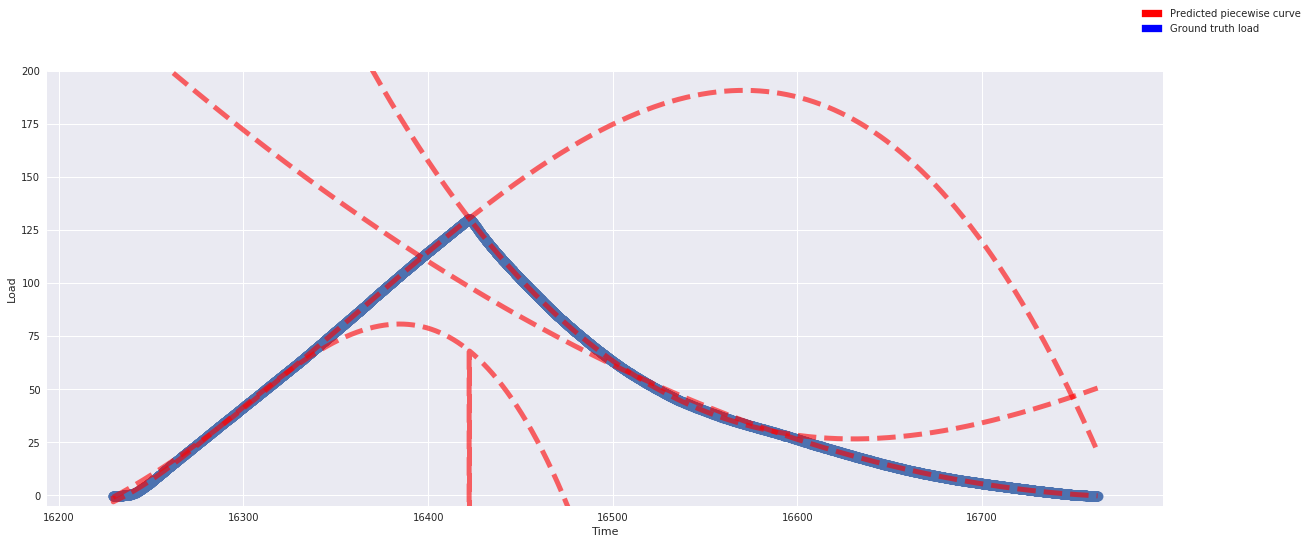

In [55]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(figsize=(20, 8))
plt.ylim(-5,200)
sns.regplot('Time', 'Load', cycle, fit_reg=False, scatter_kws={"alpha":0.9,"s":100})
for est in range(4):
    pred = ests[est].predict(sani_cycle)
    axes.plot(sani_cycle.Time, pred, linewidth=5, linestyle='--', alpha=0.6, c='r')

red_patch = mpatches.Patch(color='blue', label='Ground truth load')
blue_patch = mpatches.Patch(color='red', label='Predicted piecewise curve')
fig.legend(handles=[blue_patch, red_patch])
fig.show()

### _4_-curve generation from estimated derived features

Time 0.0
Min 1.0
Max 1.0
Load 0.0
Cycle 0.0
Area 0.0
Heating 0.0
Cooling 0.0
HCprop 0.0
Period 0.0
Tail 0.0
Belly 0.0
Kurt 0.0
Skew 0.0
           Time  Min  Max      Cycle          Area     Heating     Cooling  \
0     11367.600  1.0  0.0  36.999854  13964.153874  108.608281  283.724809   
1     11367.700  1.0  0.0  36.999854  13964.679580  108.612295  283.728432   
2     11367.800  1.0  0.0  36.999854  13965.205285  108.616310  283.732055   
3     11367.899  1.0  0.0  36.999854  13965.725733  108.620285  283.735642   
4     11368.000  1.0  0.0  36.999854  13966.256696  108.624340  283.739301   
5     11368.100  1.0  0.0  36.999854  13966.782402  108.628355  283.742924   
6     11368.200  1.0  0.0  36.999854  13967.308107  108.632369  283.746547   
7     11368.300  1.0  0.0  36.999854  13967.833813  108.636384  283.750170   
8     11368.399  1.0  0.0  36.999854  13968.354261  108.640359  283.753756   
9     11368.500  1.0  0.0  36.999854  13968.885224  108.644414  283.757416   
10    

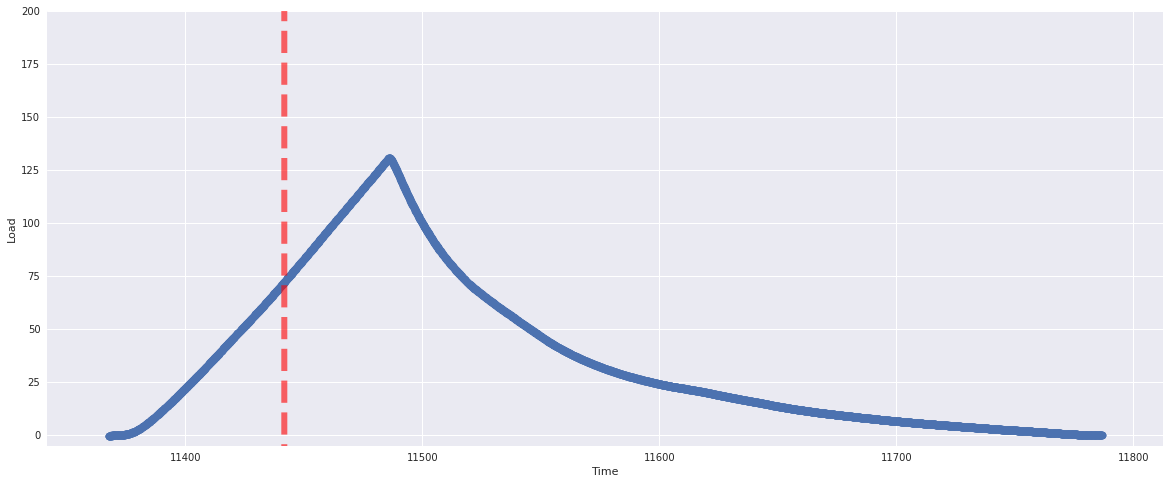

In [59]:
fig, axes = plt.subplots(figsize=(20, 8))
plt.ylim(-5,200)

X = pd.DataFrame()
cycle = df[df.Cycle==37]
test_cycle = cycle.drop(['Datetime'], axis=1).fillna(0) #TEMP

# predict features from time and cyle #
for feature in features:
    X[feature] = best_est[feature][0].predict(test_cycle[['Time', 'Cycle']])#[test_cycle.Min==1])
    print(feature, best_est[feature][0].score(test_cycle[['Time', 'Cycle']][test_cycle.Min==1], test_cycle[feature][test_cycle.Min==1]))
X.drop('Load', axis=1, inplace=True)
print(X)

# predict load from predicted features
sns.regplot('Time', 'Load', test_cycle, fit_reg=False, scatter_kws={"alpha":0.9,"s":60})
#ests, limits = cycle_ridge(cycle.drop('Load', axis=1), cycle.Load)
for est in range(4):
    pred = ests[est].predict(X)
    axes.plot(test_cycle.Time, pred, linewidth=6, linestyle='--', alpha=0.6, c='r')

In [56]:
ests

[Pipeline(memory=None,
      steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('reg', Ridge(alpha=1.2000000000000002, copy_X=True, fit_intercept=True,
    max_iter=None, normalize=False, random_state=None, solver='auto',
    tol=0.001))]), Pipeline(memory=None,
      steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('reg', Ridge(alpha=1.2000000000000002, copy_X=True, fit_intercept=True,
    max_iter=None, normalize=False, random_state=None, solver='auto',
    tol=0.001))]), Pipeline(memory=None,
      steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('reg', Ridge(alpha=6.7, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001))]), Pipeline(memory=None,
      steps=[('poly', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('reg', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, ma